In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import (gru_module_1, gru_module_2, gru_module_3, gru_module_4, neuralGrU)
from GrU import (evaluate, GrU, getBestExporter, getCost)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [3]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Neural GrU

### Experiment -> Verify the output of Module-1

In [5]:
prices = getPriceVectors(100) * 1e2
eta = 1

pi_tilda_gru = []
i_t_gru = []

for t in range(24):
    pi, i = getBestExporter(prices, t, eta, eta)
    pi_tilda_gru.append(pi)
    i_t_gru.append(i)

m1 = gru_module_1(device, eta, eta)

pi_s = torch.tensor(prices[source.storage])
pi_c = torch.tensor(prices[source.charge])
pi_g = torch.tensor(prices[source.grid])

pi_tilda_nn, i_t_nn = m1(pi_s, pi_c, pi_g, B=1e2)

In [7]:
i_t_gru

[-1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [8]:
torch.argmax(i_t_nn, dim=1)

tensor([0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [9]:
i_t_gru - torch.argmax(i_t_nn, dim=1).numpy()

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [10]:
pi_tilda_nn - torch.tensor(pi_tilda_gru)

tensor([        nan, -1.2158e-06, -4.4983e-07,  5.6641e-07, -6.5430e-07,
         9.4788e-07,  7.1899e-07,  4.1382e-07,  1.0864e-07, -1.9653e-07,
        -5.0171e-07, -8.0688e-07,  7.9529e-07,  4.9011e-07,  1.8494e-07,
        -1.2024e-07,  4.1382e-07, -1.2024e-07,  4.1382e-07, -1.2024e-07,
         7.1899e-07, -4.3945e-08, -8.0688e-07,  3.3752e-07],
       dtype=torch.float64, grad_fn=<SubBackward0>)

### Experiment -> Verify the output of Module-2

In [14]:
pi_d = torch.tensor(prices[source.discharge])
pi_p = torch.tensor(prices[source.pv])

m2 = gru_module_2(eta)
act_nn = m2(pi_tilda_nn, pi_d, pi_p, pi_g, B=1e2)
torch.argmax(act_nn, dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
# Customized GrU module to return activations as well // Reverted back to normal.
_, _, A = GrU(np.ones((24,)), prices)
A

array([2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [16]:
A - torch.argmax(act_nn, dim=1).numpy()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

### Experiment -> Verify the output(s) of Neural GrU Modules with toy example

> Outdated code; needs to be updated.

In [ ]:
B = 1e3

m1 = gru_module_1()
m2 = gru_module_2()
m3 = gru_module_3()
m4 = gru_module_4()

pi_g = torch.tensor([2, 4, 8, 1] + [1] * 20, dtype=float)
pi_p = torch.tensor([1, 2, 4, 2] + [2] * 20, dtype=float)
pi_c = torch.ones(24, dtype=float)
pi_d = torch.ones(24, dtype=float)
pi_s = torch.ones(24, dtype=float)

d_t = torch.ones(24)

pi_tilda_c_t, i_t = m1(pi_s, pi_c, pi_g, B)
a_t = m2(pi_tilda_c_t, pi_d, pi_p, pi_g, B)
i_tilda_t = m3(i_t)
d_star = m4(d_t, i_t, a_t, i_tilda_t)

In [ ]:
print('grid prices =',pi_g[:5])
print('pv prices =',pi_p[:5])
print('storage prices =',pi_s[:5])
print('charging prices =',pi_c[:5])
print('discharging prices =',pi_d[:5])

> Output of Module-1: Price of importing power from cheapest time slot

In [ ]:
pi_tilda_c_t[:6]

In [ ]:
torch.argmax(i_t[:6], dim=1)

> Output of Module-2: Cheapest source b/w discharge(incuding import from cheapest time slot), pv & grid

In [ ]:
a_t[:6]

> Output of Module-3: Time slots (one hot vector) to store the charge to be discharged at time slot t

In [ ]:
i_tilda_t[:6]

> Output of Module-4

In [ ]:
d_star[:, :6]

### Experiment -> Forward pass of Neural GrU

In [15]:
eta = 0.9487

In [16]:
m = neuralGrU(B=1e3, eta_c=eta, eta_d=eta)

prices = getPriceVectors(100) * 100
d_total = np.ones(24)

pi = torch.tensor(prices)
d_t = torch.tensor(d_total)

d_break, _ = GrU(d_total, prices, eta_c=eta, eta_d=eta)
d_break_nGrU = m(pi[0], pi[1], pi[2], pi[3], pi[4], d_t).detach().numpy()

In [22]:
evaluate(d_break, d_break_nGrU)[0]

[1.4802973661668753e-16, 0.0, 1.7393494052460785e-15, 0.0, 0.0]

In [20]:
d_break_nGrU.round(3)

array([[ 1.   ,  1.   , 19.888,  1.   ,  1.   ,  1.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , 17.919, 17.919, 17.919, 17.919, 17.919, 16.865,
        15.811, 14.757, 13.703, 12.649, 11.595, 10.541,  9.487,  8.433,
         7.379,  6.324,  5.27 ,  4.216,  3.162,  2.108,  1.054,  0.   ],
       [ 0.   ,  0.   , 18.888,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.054,
         1.054,  1.054,  1.054,  1.054,  1.054,  1.054,  1.0

## Revenue Maximization

In [5]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [6]:
# Init model
eta = 1
model = neuralGrU(B=1, eta_c=eta, eta_d=eta).to(device)

#### Input Data

In [7]:
prices = getPriceVectors(100)

# Random total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimization schedule

In [8]:
# Hyperparameter(s)
learning_rate = 1
epochs = 200

history = []

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.92)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss)

    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 200/200 [00:02<00:00, 76.65it/s]


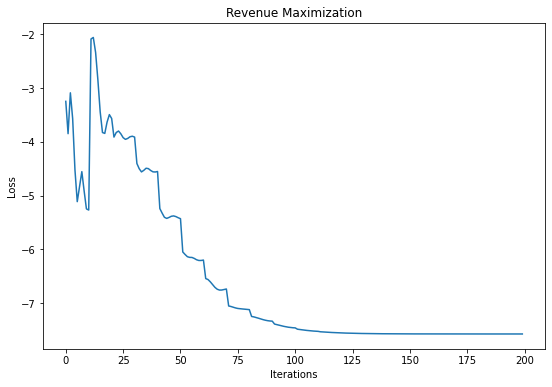

In [9]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [45]:
(pi_g > pi_p).all()

tensor(True)

In [46]:
pi_g - pi_p

tensor([0.0097, 0.0157, 0.0069, 0.0078, 0.0062, 0.0060, 0.0065, 0.0149, 0.0104,
        0.0136, 0.0096, 0.0104, 0.0107, 0.0108, 0.0106, 0.0109, 0.0106, 0.0102,
        0.0224, 0.0181, 0.0187, 0.0181, 0.0167, 0.0186], dtype=torch.float64,
       grad_fn=<SubBackward0>)

#### Demand breakup on optimised prices

In [ ]:
pi = torch.stack([pi_g, pi_p, pi_s, pi_c, pi_d]).detach().numpy()

In [ ]:
d_break_nn = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t).detach().numpy()
d_break, _ = GrU(d_t, pi, eta_c=eta, eta_d=eta)

In [ ]:
evaluate(d_break, d_break_nn)[0]

In [ ]:
d_break

## Revenue Maximization with Gradient Clipping

1. No Curriculum Learning (for B). Init B at 10-20.
2. Gradients clipped at 0, i.e., updates to price(s) are non-negative.
3. Input price tensors are scaled to compensate for lower B.
4. ExponentialLR performs better than ReduceLROnPlateau.

In [10]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [11]:
# Init model
eta = 1
B = 10
scaler = 100

model = neuralGrU(B, device, eta, eta).to(device)

#### Input Data

In [12]:
prices = getPriceVectors(100) * scaler

# Random total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimization schedule

In [13]:
# Hyperparameter(s)
learning_rate = 1e-1
epochs = 200

history_grad_clip = []

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient Clipping
    for p in [pi_p, pi_s, pi_c, pi_d]:
        p.grad = -F.relu(-p.grad)

    optimizer.step()
    scheduler.step()
    # scheduler.step(loss)

    loss = loss.item()
    history_grad_clip.append(loss / scaler)

    # Curriculum Learning
    # if t % 10 == 0 and model.B < 1e4:
    #     model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 200/200 [00:02<00:00, 80.17it/s]


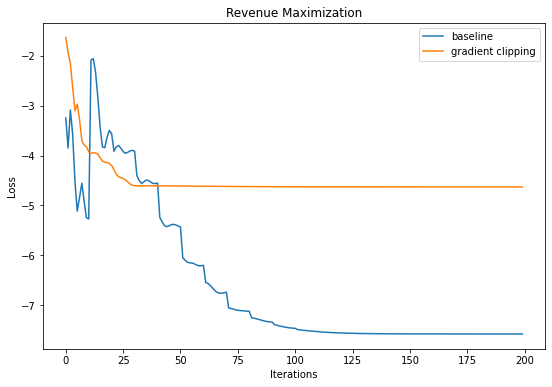

In [14]:
plt.figure(figsize=(9,6))
plt.plot(history, label='baseline')
plt.plot(history_grad_clip, label='gradient clipping')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
(pi_g > pi_p).all()

tensor(False)

In [163]:
pi_g - pi_p

tensor([ -7.2211, -13.5218, -18.2524, -20.0054, -20.9482, -20.8110, -18.4848,
        -12.0159,   2.6089,   3.0979,   1.1561,   0.2725,   0.0932,   0.0928,
          0.4586,  -0.0550,  -0.0293,  -4.8319,   0.1437,   8.5256,  10.2916,
          8.5718,   5.6218,   0.1107], dtype=torch.float64,
       grad_fn=<SubBackward0>)

In [164]:
np.round(d_star.detach().numpy())

array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

## Multi-agent Revenue Maximization

In [ ]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [ ]:
prices = getPriceVectors(300)

# Random total demand tensor
# d_t = torch.rand(24, requires_grad=False) * 10
d_t = torch.ones(24, requires_grad=False, device=device) * 10

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

# EI tensor
ep = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ep_t = torch.tensor(ep, requires_grad=False, device=device) * 1e3

In [ ]:
n_agents = 5
gamma = [1, 2, 3, 4, 5]

models = {i: neuralGrU(B=1).to(device) for i in range(n_agents)}
d_star_n = torch.tensor(np.ndarray(shape=(n_agents, 5, 24)), device=device)

# Hyperparameter(s)
learning_rate = 1
epochs = 100

history = []

optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.92)

for t in trange(epochs):
    for agent in range(n_agents):
        # Update pi_g with EI
        pi_g_ei = pi_g + gamma[agent] * ep_t
        d_star_n[agent] = models[agent](pi_g_ei, pi_p, pi_s, pi_c, pi_d, d_t)

    d_star_total = torch.sum(d_star_n, dim=0)    
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star_total)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss)

    for agent in range(n_agents):
        if t % 10 == 0 and models[agent].B < 1e4:
            models[agent].B *= 2

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(history)
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
pi_p

In [ ]:
ep_t * 3 + pi_g

In [ ]:
pi_g

In [ ]:
d_star_n[:, 1]

> PV demand of all 5 users

## Gamma Determination

In [ ]:
ei = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ei_t = np.array(ei) * 1e3

d = np.ones(24) * 5

gamma_true = 10

prices = np.ones(shape=(5, 24))
prices[source.pv] = prices[source.grid] = 1
prices[source.charge] = prices[source.discharge] = prices[source.storage] = np.inf

pi_g_true = prices[source.grid].copy()
prices[source.grid] += gamma_true * ei_t

In [ ]:
prices[:2]

In [ ]:
r = 0
ep = 1e-3

d_star, _ = GrU(d, prices)
while(not any(d_star[source.pv] == 0)):
    r += 1
    delta = np.array([(24 * (r-1) + t) for t in range(24)])
    prices[source.pv] = pi_g_true + ep * delta * ei_t

    d_star, _ = GrU(d, prices)

t = np.argwhere(d_star[source.pv] == 0)[0].item()
gamma = (24 * (r-1) + t) * ep
print(r, t, gamma)